By directly comparing the UVF_weights of [FHD](https://github.com/EoRImaging/FHD)+[$\epsilon$](https://github.com/EoRImaging/eppsilon) output and the UV coverage (uvf_cube) created by this package, we can establish the extent to which the py21cmwedge UV_coverage estimation recovers the shape of uv_weights predicted by the FHD+$\epsilon$ software.

This, along with a correlation between the shape of the uv_weights and the total power between the FoV of and instrument and the horizon, can be used to form a statistic to judge the extent to which an array can expect Foreground leakage in the wedge from an imaging analysis.

In [1]:
%matplotlib notebook
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import matplotlib.ticker as ticker
from astropy.io import fits
from matplotlib.colors import SymLogNorm, LogNorm
from py21cmwedge import UVGridder, cosmo
from scipy.io import readsav
import glob
filename='/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap'

The following function is useful to count the number of redudant baselines up to a "precision factor." Taken from [HERA-TEAM/hera_cal/redcal.py](https://github.com/HERA-Team/hera_cal/blob/master/hera_cal/redcal.py)

In [2]:
def get_reds(antpos, precisionFactor=1000000):
    """Returns an list of lists of tuples representing redundancies. Ordered by length. All baselines have the same 
    orientation with a preference for positive b_y and, when b_y==0, positive b_x where b((i,j)) = pos(i) - pos(j)."""
    keys = antpos.keys()
    reds = {}
    for i,ant1 in enumerate(keys):
        for ant2 in keys[i+1:]:
            delta = tuple((precisionFactor * (np.array(antpos[ant1]) - np.array(antpos[ant2]))).astype(int))
            if delta[1] > 0 or (delta[1]==0 and delta[0] > 0):
                if reds.has_key(delta): reds[delta] += [(ant1,ant2)]
                else: reds[delta] = [(ant1,ant2)]
            else:
                delta = tuple([-d for d in delta])
                if reds.has_key(delta): reds[delta] += [(ant2,ant1)]
                else: reds[delta] = [(ant2,ant1)]
    orderedDeltas = [delta for (delta,length) in sorted(zip(reds.keys(), [np.linalg.norm(delta) for delta in reds.keys()]))]
    return [reds[delta] for delta in orderedDeltas]

In [3]:
# Load the HFSS beam simulation of a HERA dish
beam = fits.getdata(filename, 'BEAM_X')
freqs = fits.getdata(filename, 'FREQS_X')
ind = np.argmin(abs(freqs-150e6))
beam_150 = beam[:,ind]

In [4]:
# Set up the UVGridder object for HERA 37
gridder = UVGridder()
gridder.set_uv_delta(1) # Size of pixel in the UV plane (in wavelengths)
gridder.set_beam(beam_150)
gridder.read_antpos('/home/mkolopanis/hera_sims/hera_layouts/antenna_positions_37.dat', skiprows=1)
gridder.set_freqs(150e6)
gridder.calc_all()
us_grid = np.arange(gridder.uv_size).astype(np.float64) - (gridder.uv_size -1)/2
us_grid *= gridder.uv_delta
ks_grid = cosmo.u2kperp(us_grid, 1420e6/gridder.freqs -1)

/home/mkolopanis/src/anaconda/envs/HERA/lib/python2.7/site-packages/py21cmwedge-0.0.2-py2.7.egg/py21cmwedge/uvgridder.py:237: ComplexWarning: Casting complex values to real discards the imaginary part


In [5]:
# Load up the HERA_37 FHD + Eppsilon output weights cube
weight_list = glob.glob('/home/mkolopanis/fhd_wedge_power/fhd_hera_37/ps/*weights_uvf*.idlsave')
weight_filename = weight_list.pop()
weight_file = readsav(weight_filename)

kx = weight_file.kx_rad_vals/cosmo.comoving_distance(8.47)
ky = weight_file.ky_rad_vals/cosmo.comoving_distance(8.47)
weights_cube = weight_file.weights_cube


A comparison of the uv_weights from FDH+eppsilon and the uvf_cube from py21cmwedge slices.

FDH+eppsilon is normalized for Power Spectrum estimation.

Py21cmWedge output is normalized such that the first peak (at 14.6m baselines) agrees with the number
of baselines of this type when counting from the antenna positions directly.


<IPython.core.display.Javascript object>


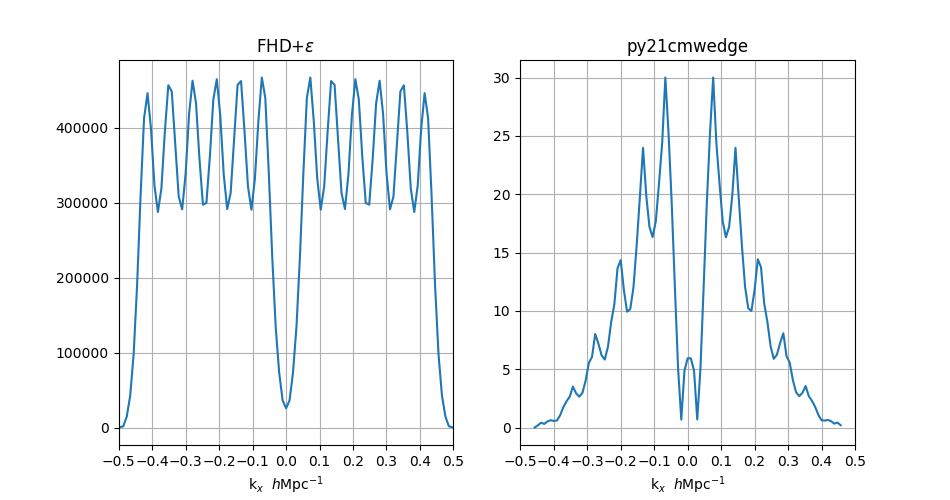

In [6]:
print "A comparison of the uv_weights from FDH+eppsilon and the uvf_cube from py21cmwedge slices.\n"
print "FDH+eppsilon is normalized for Power Spectrum estimation.\n"
print "Py21cmWedge output is normalized such that the first peak (at 14.6m baselines) agrees with the number"
print "of baselines of this type when counting from the antenna positions directly."
fig, axes = subplots(ncols=2, figsize=(9.5,5))
for i in range(axes.size):
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
    
axes[0].plot(kx, np.abs(weights_cube[512, 0, :]))
axes[0].grid()
axes[0].set_xlim([-.5,.5])
axes[0].set_title("FHD+$\epsilon$")
axes[0].set_xlabel('k$_{x}$  $h$Mpc$^{-1}$')

max_grid = np.abs(gridder.uvf_cube[0,(gridder.uv_size -1)/2]).max()
axes[1].plot(ks_grid, np.abs(gridder.uvf_cube[0,(gridder.uv_size -1)/2])/max_grid*30.)
axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
axes[1].set_xlim({-.5,.5})
axes[1].set_title('py21cmwedge')
axes[1].set_xlabel('k$_{x}$  $h$Mpc$^{-1}$')

We can check the relative heights of the p21cmwedge peaks by counting the number of redundant baselines for the 14.6, 29.2 and 43.8m 

In [7]:
antpos = gridder.antpos
ant_dict = {}
for i,ant in enumerate(antpos.T):
    ant_dict[i] = ant
reds = get_reds(ant_dict)

Number of EW 14.6m Baselines: 30
Number of EW 29.2m Baselines: 23
Number of EW 43.8m Baselines: 16
Relative 29.2/14.6:  0.766666666667
Relative 43.8/14.6:  0.533333333333


<IPython.core.display.Javascript object>


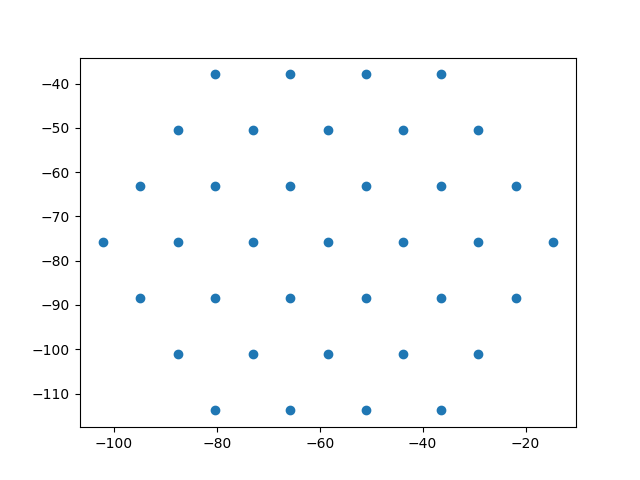

In [8]:
print "Number of EW 14.6m Baselines: 30"
print "Number of EW 29.2m Baselines: 23"
print "Number of EW 43.8m Baselines: 16"
print "Relative 29.2/14.6: ", 23/30.
print "Relative 43.8/14.6: ", 16./30.
figure()
scatter(*antpos[:2])

But we know that PRISim only outputs 1 copy of each redundant baseline type, so we should recalculate the uvf_cube from py21cmwedge using only 1 entry in each uvbin.

To accomplish this, we'll copy the object and manually set the uvbins:

In [9]:
new_dict = {}
for key in gridder.uvbins:
    new_dict[key] = [gridder.uvbins[key][0]]

In [10]:
import copy
new_gridder = copy.copy(gridder)
new_gridder.uvbins = new_dict
new_gridder.grid_uvw()

In [11]:
kx_ind = np.logical_and(kx > .05, kx < .4)
ks_ind = np.logical_and(ks_grid > .05, ks_grid < .4)

<IPython.core.display.Javascript object>


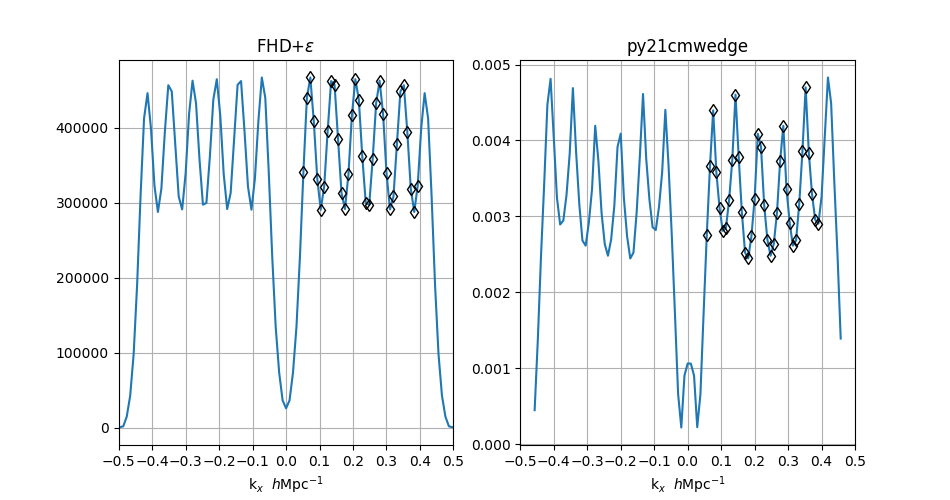

In [12]:
fig, axes = subplots(ncols=2, figsize=(9.5,5))
for i in range(axes.size):
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
    
axes[0].plot(kx, np.abs(weights_cube[512, 0, :]))
axes[0].plot(kx[kx_ind], np.abs(weights_cube[512, 0, :])[kx_ind], 'kd', mfc='none')

axes[0].grid()
axes[0].set_xlim([-.5,.5])
axes[0].set_title("FHD+$\epsilon$")
axes[0].set_xlabel('k$_{x}$  $h$Mpc$^{-1}$')

axes[1].plot(ks_grid, np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2]))
axes[1].plot(ks_grid[ks_ind], np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2])[ks_ind],
             'kd', mfc='none')

axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
axes[1].set_xlim({-.5,.5})
axes[1].set_title('py21cmwedge')
axes[1].set_xlabel('k$_{x}$  $h$Mpc$^{-1}$')

The proposed statistic we wish to use to indicate the amount of wedge leakage is the Standard devation of the weights cube divided by its mean over an arbitrarily chosen k-bin.

For an example we will consider all the k_values in the range $.05 < k < .5$ in $h$Mpc$^{-1}$

In [13]:
fhd_mean = np.mean(np.abs(weights_cube[512, 0])[kx_ind])
fhd_std = np.std(np.abs(weights_cube[512, 0])[kx_ind])
wedge_mean = np.mean(np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2])[ks_ind])
wedge_std = np.std(np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2])[ks_ind])


print "Simulation\tMean\t\tStd\t\tStd/Mean"
print "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(fhd_mean, fhd_std, fhd_std/fhd_mean)
print "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(wedge_mean, wedge_std, wedge_std/wedge_mean)

Simulation	Mean		Std		Std/Mean
FHD        	3.749e+05	6.223e+04	1.660e-01
Py21cmwedge	3.298e-03	6.110e-04	1.853e-01
